In [3]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import KFold

from skorch import NeuralNetRegressor

import torch
from torch import nn, optim                        
import torch.nn.functional as F                
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, RFECV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt

In [4]:
# Read target chemical properties and extracted fingerprints.
df = pd.read_csv('ECFP_fingerprint.csv',header = 0)

Feature_Names = df.columns
Names = df.iloc[:,1]
Y_SA = df.iloc[:,2]

X = df.iloc[:,5:].to_numpy()

print(Y_SA.shape)
print(X.shape)

(10237,)
(10237, 2048)


In [5]:
# Post processing : Normalize features and target property within [0,1]

Y_SA = Y_SA.values.reshape(-1,1)
sc_y = MinMaxScaler() 
sc_y.fit(Y_SA) 
Y_SA_scaled = sc_y.transform(Y_SA)

max_val = sc_y.data_max_

In [6]:
class TensorData(Dataset):

    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = self.y_data.shape[0]

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index] 

    def __len__(self):
        return self.len

In [7]:
# Split train/test dataset

X_train, X_test, Y_train, Y_test = train_test_split(X, Y_SA_scaled, test_size = 0.2, shuffle = True, random_state = 42)


trainsets = TensorData(X_train, Y_train)

testsets = TensorData(X_test, Y_test)

print(f'train data : {trainsets.__len__()}, test data : {testsets.__len__()}')

train data : 8189, test data : 2048


In [8]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2048, 1024, bias=True) 
        self.fc2 = nn.Linear(1024, 1024, bias=True)
        self.fc3 = nn.Linear(1024, 1, bias=True)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.fc1(x)) 
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))

        return x

In [9]:
# Set up Regressor

net = NeuralNetRegressor(Regressor(),optimizer=torch.optim.Adam)

In [14]:
# Train DNN using Grid Search Cross Validation
# To test DNNs with different depths, modify Regressor class assigned above
# Grid search could take several hours. Narrow down the search space if necesarry.

params = {
    'lr': [0.0001, 0.0005, 0.001],
    'max_epochs': [100,200],
    'batch_size': [32,64],
}

grid_cv = GridSearchCV(net ,param_grid = params, cv=5, n_jobs = -1)

X_train = X_train.astype(np.float32)
Y_train = Y_train.astype(np.float32)

grid_cv.fit(X_train, Y_train)

best_model = grid_cv.best_estimator_

print(grid_cv.best_score_, grid_cv.best_params_)

  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        0.0124        0.0082  20.6420
  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        0.0127        0.0079  21.1015
  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        0.0123        0.0085  21.3015
  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        0.0127        0.0076  21.2246
  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        0.0128        0.0070  21.4489
  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        0.0130        0.0077  21.7878
  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        0.0128        0.0069  21.4015
  epoch    train_loss    valid_loss      dur
-------  -

KeyboardInterrupt: 

In [21]:
# Compute R2 score and MAE

from sklearn.metrics import r2_score

X_train_rescaled = X_train * max_val 
Y_train_rescaled = Y_train * max_val 

X_test_rescaled = X_test * max_val 
Y_test_rescaled = Y_test * max_val 


Y_train_pred = best_model.predict(X_train) * max_val 
Y_test_pred = best_model.predict(X_test) * max_val 

r2_train = r2_score(Y_train_rescaled, Y_train_pred)
r2_test = r2_score(Y_test_rescaled, Y_test_pred)

print('R2 Score - train : %3f test : %3f' %(r2_train, r2_test))

train_error = [abs(a - b) for a, b in zip(Y_train_rescaled, Y_train_pred)]
train_mae = sum(train_error) / len(Y_train_rescaled)

test_error = [abs(a - b) for a, b in zip(Y_test_rescaled, Y_test_pred)]
test_mae = sum(test_error) / len(Y_test_rescaled)

print('MAE - Train : %.3f, Test : %3f' %(train_mae, test_mae))



R2 Score - train : 0.946980 test : 0.795098
MAE - Train : 96.645, Test : 254.511541


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


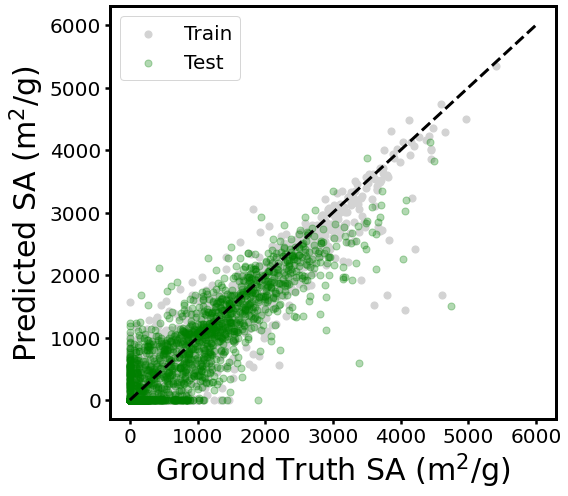

In [22]:
# Plot parity plot

import matplotlib.pyplot as plt

import matplotlib as mpl


plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.axisbelow'] = True
#plt.rc('xtick', labelsize=24)
#plt.rc('ytick', labelsize=24)
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 2.5
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 2.5
mpl.rcParams['axes.linewidth'] = 3
plt.rcParams['font.size']=24

plt.figure(figsize=(8,7))

plt.scatter(Y_train_rescaled,Y_train_pred,c='lightgray',marker='o', label='Train', s = 50)
plt.scatter(Y_test_rescaled,Y_test_pred,c='green',alpha=0.3, marker='o', label='Test', s = 50)

a = np.linspace(0,6000)
plt.plot(a,a,c='black',linestyle='dashed',linewidth=3)

plt.ylabel('Predicted SA (m$^2$/g)', fontsize = 30)
plt.xlabel('Ground Truth SA (m$^2$/g)', fontsize = 30)
plt.legend(prop={'size': 20})

plt.xticks([0,1000,2000,3000,4000,5000,6000], fontsize = 20)
plt.yticks([0,1000,2000,3000,4000,5000,6000], fontsize = 20)

plt.tight_layout()

plt.savefig('ECFP_SA.svg', dpi=500, format = 'svg')
